# Assignment2 Classify Images of Road Traffic Signs
Load necessary packages

In [1]:
import tensorflow as tf
import IPython.display as display
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import glob
import skimage
from PIL import Image
from pathlib import Path
from sklearn import svm, metrics, datasets
from sklearn.utils import Bunch
from sklearn.model_selection import GridSearchCV, train_test_split
from skimage.io import imread
from skimage.transform import resize
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda, Input
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

# use following command if cannot import skimage, then restart kernel
# !conda install -c conda-forge scikit-image --yes
%matplotlib notebook

Using TensorFlow backend.


load data and categorized

In [2]:
def load_img_data():
    image_list = []
    #transfer file name to target name
    for filepath in glob.glob('trafficsigns_dataset/*/*/*.png', recursive = True):
        filename = filepath.split("/")[-1]
        sign_shape = filepath.split("/")[1]
        sign_type = filepath.split("/")[2]
        image_list.append((filepath, sign_shape, sign_type))
        
    data = pd.DataFrame(data=image_list, columns=['image_path','sign_shape', 'sign_type'])
    return data

split data into training, validating data. not spliting into validating data is because we will be using other images for testing

In [3]:
trainData, validationData = train_test_split(load_img_data(), test_size=0.2, random_state=1) # 0.25 x 0.8 = 0.2
print('Train size: {}, Test size: {}'.format(trainData.shape[0], validationData.shape[0] ) )
train_size = trainData.shape[0]
validation_size = validationData.shape[0]

Train size: 2954, Test size: 739


# Below are serveral of function defined for training
create and config a deep learning model cnn. varioius configuration will be tuned to get the best model in a single function

def data_generator(trainData, testData, target):
    train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
    val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

    batch_size = 16

    train_generator = train_datagen.flow_from_dataframe(
            dataframe=trainData,
            directory='./',
            x_col="image_path",
            y_col=target,
            target_size=(28, 28),
            batch_size=batch_size,
            class_mode='categorical')

    validation_generator = val_datagen.flow_from_dataframe(
            dataframe=testData,
            directory='./',
            x_col="image_path",
            y_col=target,
            target_size=(28, 28),
            batch_size=batch_size,
            class_mode='categorical')
    return train_generator, validation_generator

In [ ]:
since we need to tunning seperatly, it is better to seperate the function

In [5]:
def create_model_for_shapes():
    model = Sequential()

    # input
    model.add(Input(shape=(28, 28, 3)))
    # change back to 1 channel
    model.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 

    # Layer 1 with 32 depth, 3x3 kernel, weight 0.01
    model.add(Conv2D(16, (5, 5),kernel_regularizer=regularizers.l2(0.001)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # MLP
    v.add(Flatten())  # this converts feature maps to 1D feature vectors
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(5))
    model.add(Activation('softmax'))

    sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=[categorical_accuracy])

    return model

In [6]:
def create_model_for_types():
    model = Sequential()

    # input
    model.add(Input(shape=(28, 28, 3)))
    # change back to 1 channel
    model.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 

    # Layer 1 with 32 depth, 3x3 kernel, weight 0.001
    model.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.001)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Layer 1 with 32 depth, 3x3 kernel, weight 0.001
    model.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.001)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # MLP
    model.add(Flatten())  # converts to 1D feature vectors
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(16))
    model.add(Activation('softmax')) # final layer

    sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=[categorical_accuracy])

    return model

train the model and validate

In [7]:
def train_model(model_, train_generator_in, validation_generator_in, num_epoch=50, verbose=False):
    batch_size = 16
    res = []
    for e in range(num_epoch):
        batches = 0

        loss_ = []
        acc_ = []

         # iterate over each batch
        for x,y in train_generator_in:
            loss, acc = model_.train_on_batch(x, y) # actual trainning and return looses and accuracy per batch
            loss_.append(loss)
            acc_.append(acc)
            batches += 1
            if batches >= train_size / batch_size:
                # break when needed
                break
        loss_ = np.mean(loss_)
        acc_ = np.mean(acc_)

        loss, acc = calculate_losses(model_, validation_generator_in, validation_size, batch_size)
        if verbose:
            print("Training epoch {}: Loss = {}, Accuracy = {}".format(e, loss_, acc_))
            print("Validation epoch {}: Loss = {}, Accuracy = {}".format(e, loss, acc))

        res.append((e, loss_, acc_, loss, acc))
    return np.asarray(res)

evaluate the model by validating data.

In [8]:
def calculate_losses(model_in, data_generator_in, N_images, batch_size_):
    loss_hold = []
    acc_hold = []
    batches = 0
    
    # iterate over each batch
    for x,y in data_generator_in:
        loss, acc = model_in.evaluate(x, y, verbose=0) # evalute the model and return looses and accuracy
        loss_hold.append(loss)
        acc_hold.append(acc)
        batches += 1
        if batches >= N_images / batch_size_:
            # break when needed
            break
            
    return np.mean(loss_hold), np.mean(acc_hold)

draw the graph and print numerical accuracy for evaluation

In [9]:
def plot_results(res):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(res[:,0], res[:,1], 'r-')
    plt.plot(res[:,0], res[:,3], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.ylim([0, np.max([5., np.max(res[:,1]), np.max(res[:,3])])])
    print("Losses: ", res[:,3]);

    plt.subplot(1,2,2)
    plt.plot(res[:,0], res[:,2], 'r-')
    plt.plot(res[:,0], res[:,4], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, np.max([1., np.max(res[:,2]), np.max(res[:,4])])])
    
    print("Accuracy: ", res[:,4]);

generate traning and validating data to fit the model, after final tunning, 20 epoch is the best fit for shape and 80 is for types.

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Found 2954 validated image filenames belonging to 5 classes.
Found 739 validated image filenames belonging to 5 classes.
Losses:  [0.32377605 0.14973314 0.09122857 0.09164659 0.08096495 0.06470976
 0.06286474 0.05770712 0.05092113 0.05608934 0.06423577 0.0652686
 0.06416227 0.06172914 0.06194216 0.06227789 0.06411393 0.06087517
 0.06333042 0.05714246]
Accuracy:  [0.92154253 0.95567381 0.97739363 0.98005319 0.98404253 0.9893617
 0.99335104 0.99202126 0.99202126 0.99069148 0.99069148 0.99069148
 0.99202126 0.99468082 0.99069148 0.99202126 0.99069148 0.99468082
 0.99202126 0.99202126]


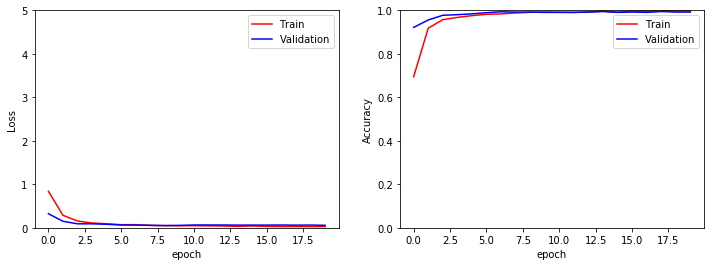

In [10]:
model_shapes = create_model_for_shapes()
train_generator, validation_generator = data_generator(trainData, validationData, "sign_shape")
res = train_model(model_shapes, train_generator, validation_generator, num_epoch=20, verbose=False)
plot_results(res)

Found 2954 validated image filenames belonging to 16 classes.
Found 739 validated image filenames belonging to 16 classes.
Losses:  [1.13206576 0.53558485 0.40294583 0.31501639 0.23802198 0.22838169
 0.19068302 0.16351967 0.14607126 0.16689697 0.15806209 0.14251971
 0.13109093 0.14148999 0.12928212 0.13864417 0.11798601 0.11971916
 0.12326565 0.10424299 0.12141563 0.11738785 0.12670942 0.09991916
 0.09591041 0.10168871 0.10628721 0.10112739 0.11067139 0.08967344
 0.08971415 0.08509823 0.09218626 0.08991686 0.09680478 0.08680424
 0.08603876 0.09658179 0.0832316  0.08763542 0.08381023 0.08052746
 0.07560149 0.0848648  0.07858387 0.07469804 0.07546769 0.06883124
 0.08999999 0.07480486 0.07581023 0.06747971 0.09420137 0.06998751
 0.06810802 0.06847035 0.08363483 0.07343797 0.0688065  0.08283366
 0.06429944 0.06734042 0.06353925 0.07795111 0.08235096 0.07479168
 0.08728219 0.06751355 0.08685819 0.06731418 0.07499885 0.0629775
 0.06521349 0.06886404 0.06528827 0.06373478 0.06887825 0.0645011

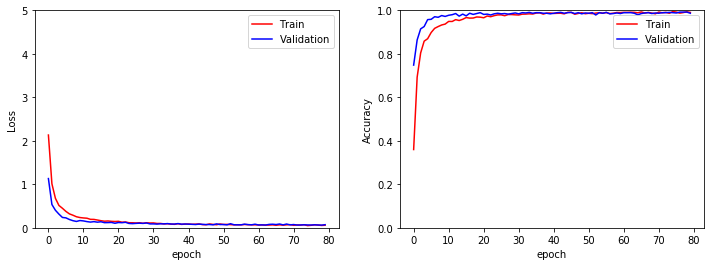

In [11]:
model_types = create_model_for_types()
train_generator, validation_generator = data_generator(trainData, validationData, "sign_type")
res = train_model(model_types, train_generator, validation_generator, num_epoch=80, verbose=False)
plot_results(res)

# for the actual model and testing test data.

In [12]:
def load_image(img_path):

    img = image.load_img(img_path, target_size=(28, 28))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    plt.imshow(img_tensor[0])                           
    plt.axis('off')
    plt.show()

    return img_tensor

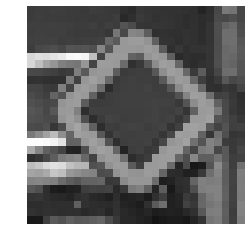

In [13]:
img = load_image("./testing_data/00032_00002.png");

In [14]:
shapes = {'diamond', 'hex', 'round', 'square', 'triangle'}
types = {'rightofway', 'stop', 'bicycle', 'limitedtraffic', 'noentry', 'noparking', 'roundabout', 'speed', 
             'trafficdirective', 'traveldirection', 'continue', 'crossing', 'laneen', 'parking', 'giveway', 'warning'}
shapes = sorted(shapes)
types = sorted(types)

In [15]:
pred = model_shapes.predict_classes(img, verbose=0)
print(shapes[pred[0]])

diamond


In [16]:
pred = model_types.predict_classes(img, verbose=0)
print(types[pred[0]])

rightofway


# Support Vector Machines
investage SVC alongside

transform original data into a sklearn dataset

In [17]:
def get_svc_dataset(data):
    #all features
    shapes = {'diamond', 'hex', 'round', 'square', 'triangle'}
    types = {'rightofway', 'stop', 'bicycle', 'limitedtraffic', 'noentry', 'noparking', 'roundabout', 'speed', 
             'trafficdirective', 'traveldirection', 'continue', 'crossing', 'laneend', 'parking', 'giveway', 'warning'}
    
    #empty set
    images = []
    flat_data = []
    shape_target = []
    type_target = []
    
    #iterate pandas set and retirve nesserary data
    for index, row in data.iterrows(): 
        img = skimage.io.imread(row['image_path'])
        img_resized = resize(img, (28, 28), anti_aliasing=True, mode='reflect')
        flat_data.append(img_resized.flatten()) 
        images.append(img_resized)
        shape_target.append(row['sign_shape'])
        type_target.append(row['sign_type'])
        
    #transform into pandas data set
    flat_data = np.array(flat_data)
    shape_target = np.array(shape_target)
    type_target = np.array(type_target)
    images = np.array(images)
    
    #return Bunch class
    dataset_for_shape = Bunch(data=flat_data,target=shape_target,target_names=shapes,images=images)
    dataset_for_type = Bunch(data=flat_data,target=type_target,target_names=types,images=images)
    return dataset_for_shape, dataset_for_type

split data into trainning and testing

In [18]:
dataset_for_shape, dataset_for_type = get_svc_dataset(load_img_data())
train_shape_X, test_shape_X, train_shape_Y, test_shape_Y = train_test_split(dataset_for_shape.data, dataset_for_shape.target, test_size=0.3,random_state=1)
train_type_X, test_type_X, train_type_Y, test_type_Y = train_test_split(dataset_for_type.data, dataset_for_type.target, test_size=0.3,random_state=1)

note the parameter here is for different model and modification

In [19]:
parameter = [{'C': [1, 10, 100, 1000], 'kernel': ['linear']}, {'C': [1, 10, 100, 1000], 'gamma': [0.01, 0.001], 'kernel': ['rbf']},]

below are two model for validate shape and type

In [20]:
svc_shape = svm.SVC()
model_shape = GridSearchCV(svc_shape, parameter)
model_shape.fit(train_shape_X, train_shape_Y)
pred_shape_Y = model_shape.predict(test_shape_X)
print(model_shape, metrics.classification_report(test_shape_Y, pred_shape_Y))

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000], 'gamma': [0.01, 0.001],
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)               precision    recall  f1-score   support

     diamond       0.99      0.90      0.94       100
         hex       1.00      0.92      0.96        12
       round       0.96      1.00      0.98    

In [21]:
print(model_shape, metrics.classification_report(test_shape_Y, pred_shape_Y))

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000], 'gamma': [0.01, 0.001],
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)               precision    recall  f1-score   support

     diamond       0.99      0.90      0.94       100
         hex       1.00      0.92      0.96        12
       round       0.96      1.00      0.98    

In [22]:
svc_type = svm.SVC()
model_type = GridSearchCV(svc_type, parameter)
model_type.fit(train_type_X, train_type_Y)
pred_type_Y = model_type.predict(test_type_X)
print(model_type, metrics.classification_report(test_type_Y, pred_type_Y))

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000], 'gamma': [0.01, 0.001],
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)                   precision    recall  f1-score   support

         bicycle       0.92      0.98      0.95        86
        continue       0.98      0.94      0.96        54
        crossing       1.00      0.